# Imports

In [1]:
# !pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 676.4 kB/s eta 0:00:00--:--


In [22]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50 , preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D,GlobalMaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
#from tensorflow_addons.metrics import F1Score
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
import tensorflow as tf
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import requests
from PIL import Image
from io import BytesIO


In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
epochs = 30

In [4]:
from os import listdir
from os.path import join, isfile
files = listdir('/kaggle/input/data-weather/data/train')
files = [f.lower() for f in files]   # Convert to lower case
sorted(files)

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

In [5]:
label =files
NUM_CLASS=len(label)

In [20]:
def plot_class_counts(train_generator):
    # class labels
    class_labels = list(train_generator.class_indices.keys())

    #class indices for each batch
    class_indices_list = []
    for i in range(len(train_generator)):
        _, batch_labels = train_generator[i]
        class_indices_list.extend(np.argmax(batch_labels, axis=1))

    # occurrences of each class
    unique_classes, class_counts = np.unique(class_indices_list, return_counts=True)

    # DataFrame for plotting
    data = pd.DataFrame({
        'Class': [class_labels[i] for i in unique_classes],
        'Count': class_counts
    })

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Class', y='Count', data=data)
    plt.title('Class Counts in Training Data')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


## Before Data Augumentaion


In [24]:
# Before Augumentaion ...
rescale_factor = 1.0 / 255.0

train_img_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=rescale_factor,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.15
)

val_img_gen = ImageDataGenerator(rescale=rescale_factor, 
                                 validation_split=0.15)

In [32]:
# Create training and validation datasets
train_ds = train_img_gen.flow_from_directory(
    directory='/kaggle/input/data-022/dataset',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=128,
    class_mode='categorical',
    subset='training',
    seed=42)

val_ds = val_img_gen.flow_from_directory(
    directory='/kaggle/input/data-022/dataset',
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    seed=42)

Found 5839 images belonging to 11 classes.
Found 1023 images belonging to 11 classes.


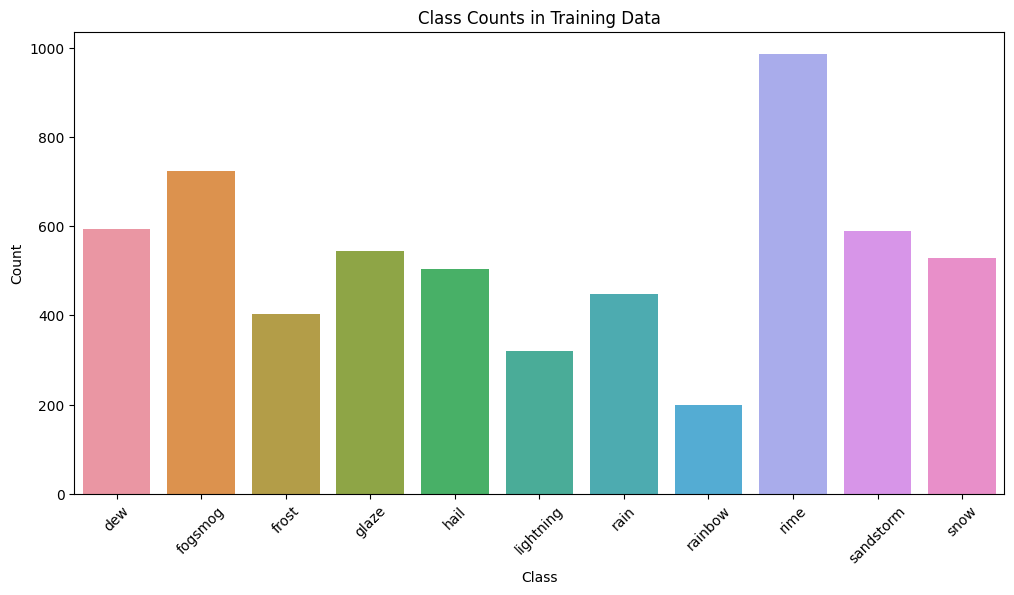

In [33]:
plot_class_counts(train_ds)

## As we can see the data NOT balanced So we need some data Augumentaion 


# After Data Augumentaion ...


In [6]:
train_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
#     horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

# Only rescaling the val set
val_gen = ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
#     preprocessing_function = efn.preprocess_input
)

In [34]:
train_generator = train_gen.flow_from_directory(
    directory="/kaggle/input/data-weather/data/train",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=42
)
valid_generator = val_gen.flow_from_directory(
    directory='/kaggle/input/data-weather/data/test',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

Found 11109 images belonging to 11 classes.
Found 1967 images belonging to 11 classes.


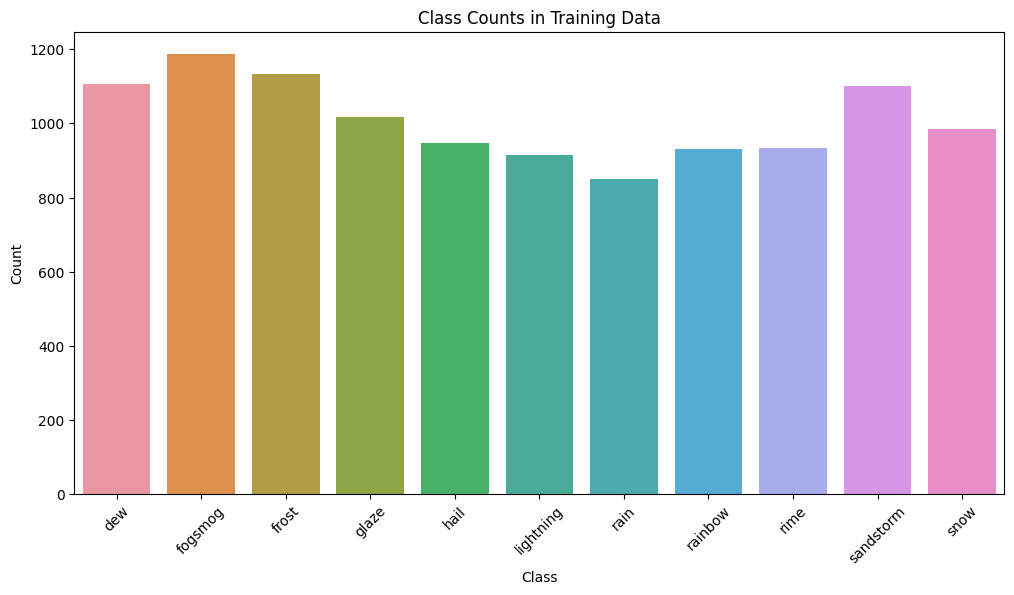

In [23]:
plot_class_counts(train_generator)

##  As we can see the data more balanced , After data augumentaion .

In [9]:
class_dict= {v:k for k,v in train_generator.class_indices.items()}
class_dict

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

In [10]:
class_dict= {v:k for k,v in valid_generator.class_indices.items()}
class_dict

{0: 'dew',
 1: 'fogsmog',
 2: 'frost',
 3: 'glaze',
 4: 'hail',
 5: 'lightning',
 6: 'rain',
 7: 'rainbow',
 8: 'rime',
 9: 'sandstorm',
 10: 'snow'}

## EDA for Training and Validation set ( Sample for images ) :-

In [11]:
def see_examples(datagen, figsize=(16,16),nrows=4, ncols=4):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    batch_idx = np.random.randint(low=0, high=len(datagen), size=(nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            imgs, labels = datagen[batch_idx[i,j]]
            sample_idx = np.random.randint(low=0, high=len(imgs))
            img = imgs[sample_idx]
            label = labels[sample_idx]
            label = class_dict[np.argmax(label)]
            ax[i,j].axis('off')
            ax[i,j].imshow(img)
            ax[i,j].set_title(label)
    plt.show()

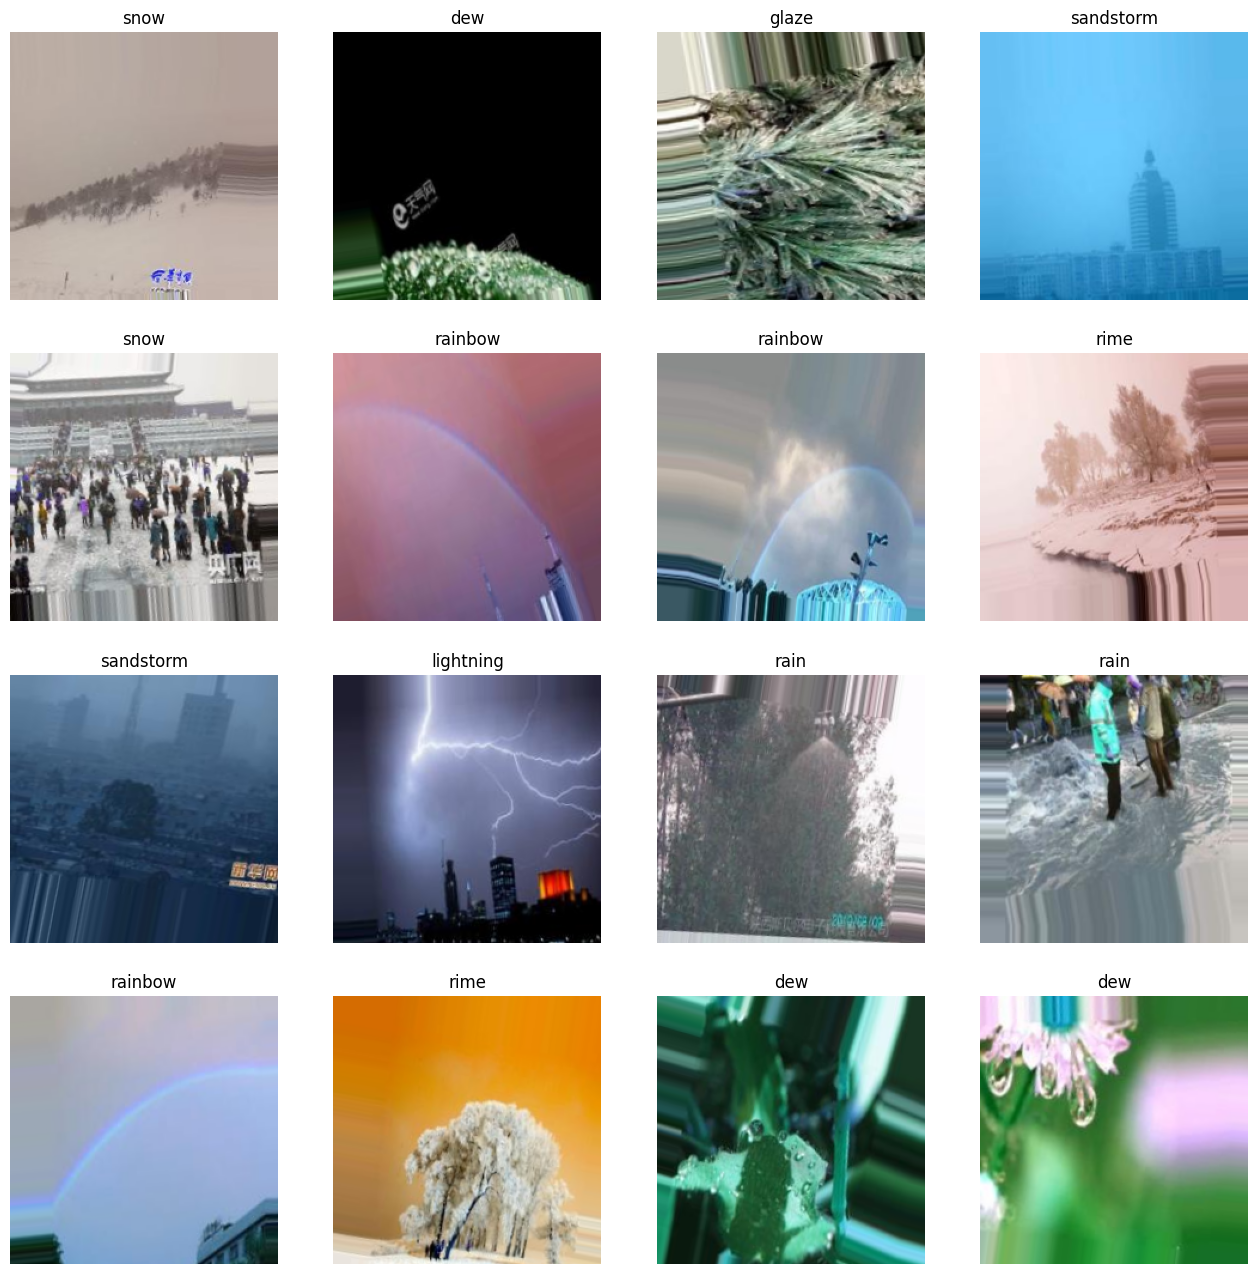

In [12]:
see_examples(train_generator)

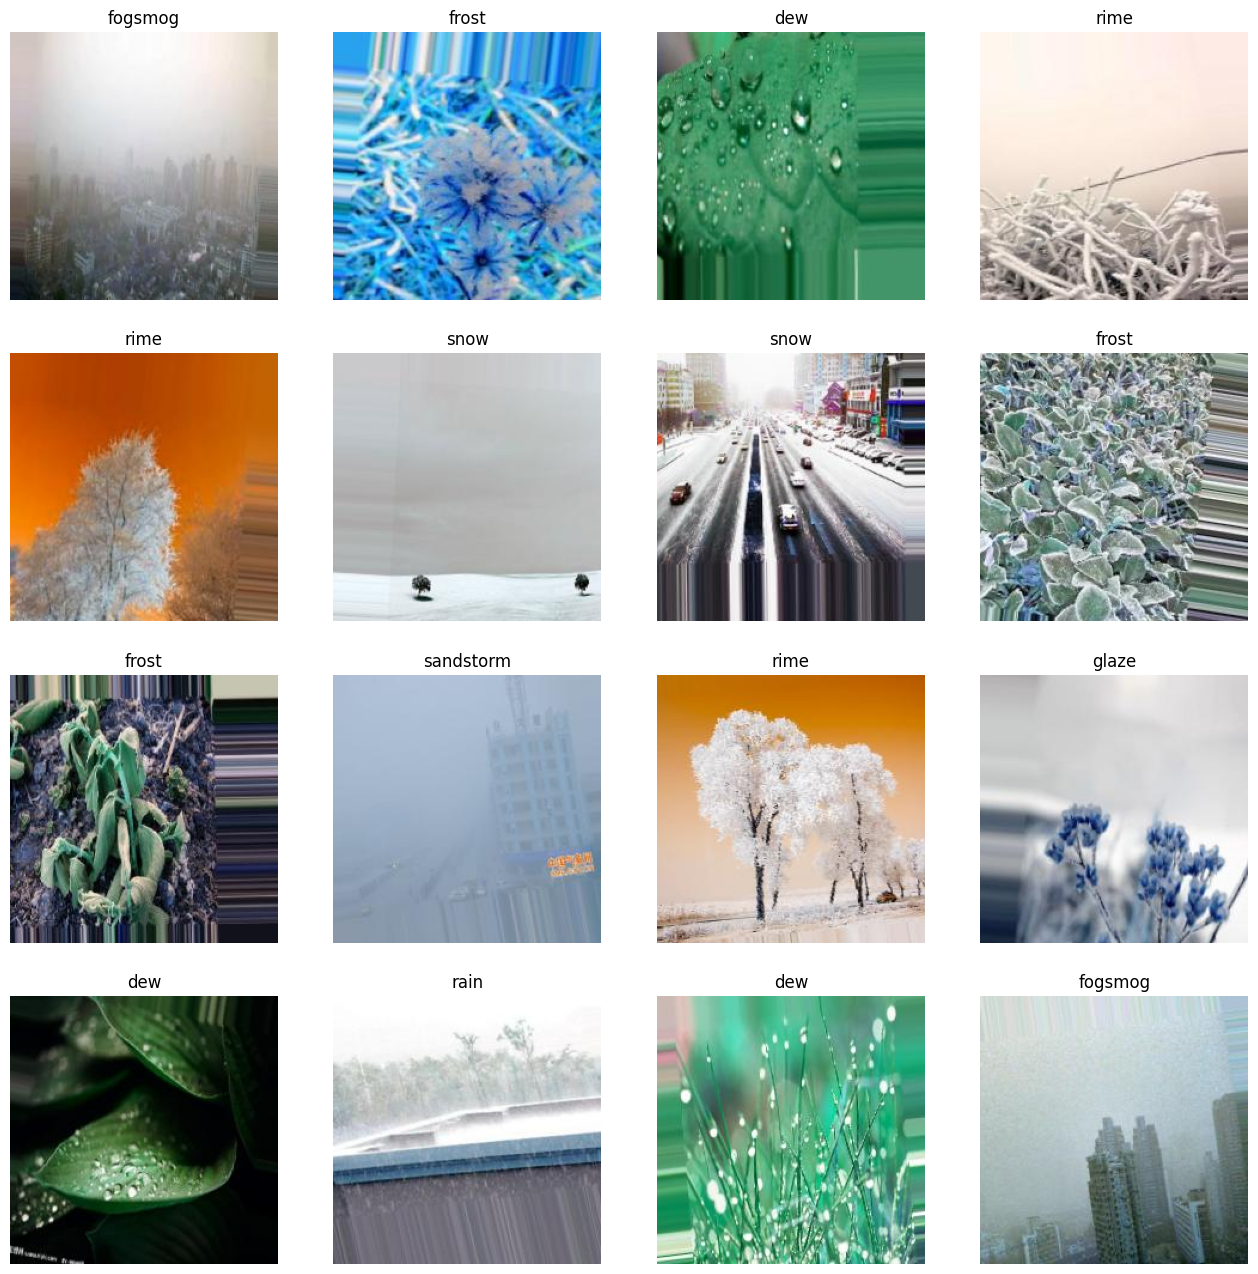

In [13]:
see_examples(valid_generator)

## Model Building Using Transfer Learning ( EfficientNetB0 ) Was the best Model :-

In [14]:
conv_base = efn.EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))
conv_base.trainable = True

16804768/16804768 [==============================] - 0s 0us/step


In [15]:
# conv_base.trainable = True

# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'block6a_expand_conv':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False 

In [16]:
model = Sequential([
    conv_base,
    GlobalAveragePooling2D(),
    
    Dense(units=512,activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=NUM_CLASS, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [18]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=8),
    ModelCheckpoint('best_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.001)
]

metrics = [
    CategoricalAccuracy(), 
    F1Score(num_classes=NUM_CLASS), 
    Precision(), 
    Recall(), 
#     AUC()
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [19]:
from sklearn.utils.class_weight import compute_class_weight


class_labels = train_generator.classes
# Calculate class weights
class_weights = compute_class_weight('balanced' ,classes=np.unique(class_labels), y=class_labels)

# Create a dictionary to map class indices to their respective class weights
class_weight_dict = dict(enumerate(class_weights))


print(class_weight_dict)

{0: 0.9131185270425777, 1: 0.8500918273645547, 2: 0.8913584209259408, 3: 0.9930276213462054, 4: 1.067557178550836, 5: 1.102520841603811, 6: 1.1881283422459894, 7: 1.083593445181428, 8: 1.0801166747690811, 9: 0.91726529601189, 10: 1.0252884171665897}


In [20]:
history = model.fit(train_generator,epochs=50, batch_size=BATCH_SIZE,
                  validation_data=valid_generator,callbacks= callbacks,
                    class_weight = class_weight_dict
                             )

Epoch 1/50


2024-04-18 21:10:54.548164: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


174/174 [==============================] - 297s 1s/step - loss: 0.6852 - categorical_accuracy: 0.7898 - f1_score: 0.7914 - precision: 0.8817 - recall: 0.7126 - val_loss: 1.4861 - val_categorical_accuracy: 0.6355 - val_f1_score: 0.6310 - val_precision: 0.6881 - val_recall: 0.5831 - lr: 0.0010
Epoch 2/50
174/174 [==============================] - 154s 881ms/step - loss: 0.3720 - categorical_accuracy: 0.8861 - f1_score: 0.8870 - precision: 0.9171 - recall: 0.8579 - val_loss: 0.3091 - val_categorical_accuracy: 0.9039 - val_f1_score: 0.9027 - val_precision: 0.9248 - val_recall: 0.8882 - lr: 0.0010
Epoch 3/50
174/174 [==============================] - 154s 881ms/step - loss: 0.2693 - categorical_accuracy: 0.9130 - f1_score: 0.9135 - precision: 0.9332 - recall: 0.8959 - val_loss: 0.2774 - val_categorical_accuracy: 0.9136 - val_f1_score: 0.9144 - val_precision: 0.9315 - val_recall: 0.8983 - lr: 0.0010
Epoch 4/50
174/174 [==============================] - 152s 870ms/step - loss: 0.2370 - catego

# Model Evaluation :-

In [21]:
history_df = pd.DataFrame(history.history)
history_df.head()

loss  categorical_accuracy  \
0  0.685202              0.789810   
1  0.371971              0.886128   
2  0.269271              0.912953   
3  0.236971              0.924746   
4  0.205898              0.934918   

                                            f1_score  precision    recall  \
0  [0.8553875, 0.8201564, 0.7234798, 0.6167575, 0...   0.881711  0.712575   
1  [0.91835815, 0.8947812, 0.8476702, 0.7819253, ...   0.917052  0.857863   
2  [0.9526411, 0.92050207, 0.8837622, 0.83292496,...   0.933240  0.895940   
3  [0.9602529, 0.9241204, 0.90008914, 0.8519961, ...   0.938798  0.911333   
4  [0.9635627, 0.93579525, 0.9186046, 0.8721439, ...   0.946093  0.924206   

   val_loss  val_categorical_accuracy  \
0  1.486073                  0.635486   
1  0.309092                  0.903915   
2  0.277395                  0.913574   
3  0.397595                  0.880529   
4  0.277894                  0.925775   

                                        val_f1_score  val_precision  \
0  [0.66220737, 0.5265823, 0.58193976, 0.47619048...       0.688062   
1  [0.96482414, 0.9056604, 0.87901235, 0.8121827,...       0.924828   
2  [0.95652175, 0.9419954, 0.8769231, 0.8282829, ...       0.931471   
3  [0.90909094, 0.9032258, 0.87830687, 0.75384617...       0.896607   
4  [0.95897436, 0.89119166, 0.9004739, 0.86027396...       0.933713   

   val_recall     lr  
0    0.583121  0.001  
1    0.888155  0.001  
2    0.898322  0.001  
3    0.859685  0.001  
4    0.916624  0.001

In [22]:
history_df['f1_score'] = history_df['f1_score'].apply(np.mean)
history_df['val_f1_score'] = history_df['val_f1_score'].apply(np.mean)

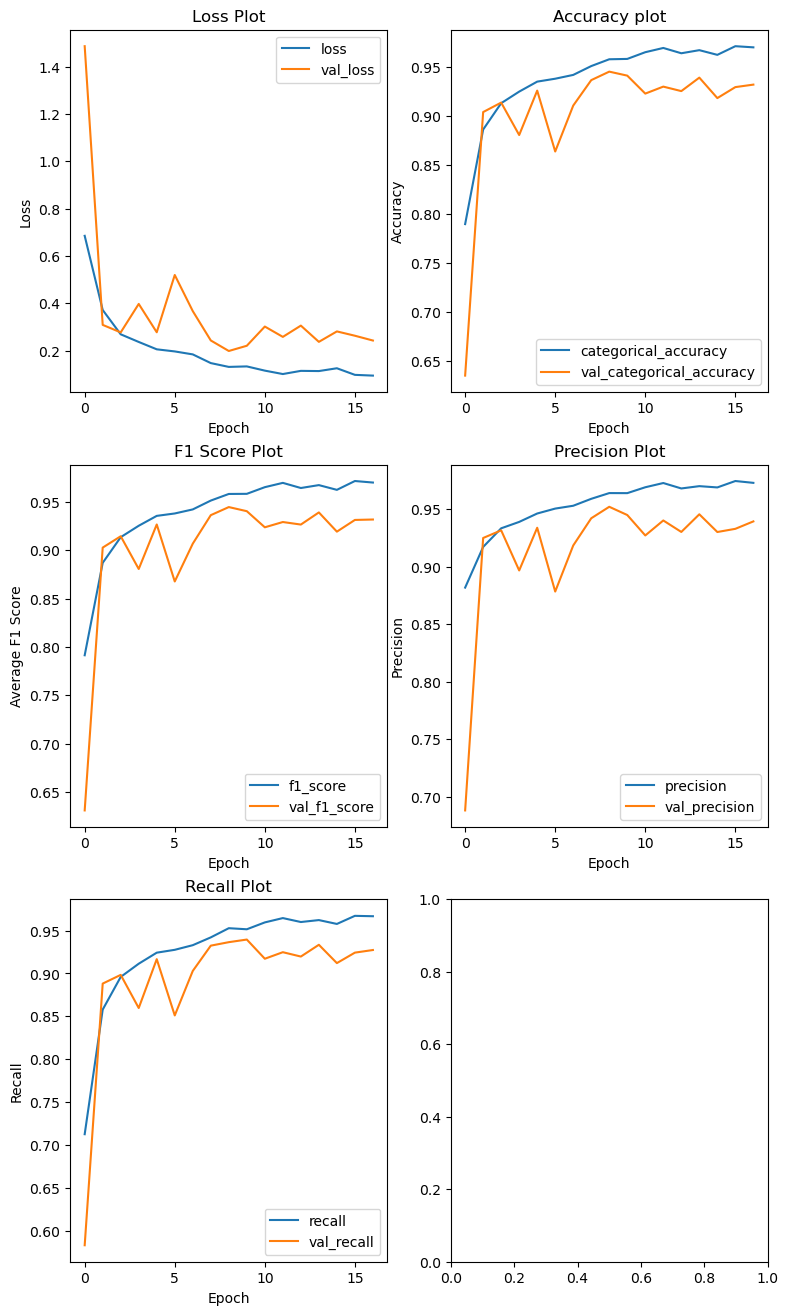

In [23]:
fig, ax = plt.subplots(figsize=(9,16), nrows=3,ncols=2)
history_df[['loss','val_loss']].plot(ax=ax[0,0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
history_df[['categorical_accuracy','val_categorical_accuracy']].plot(
    ax=ax[0,1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
history_df[['f1_score','val_f1_score']].plot(ax=ax[1,0],xlabel='Epoch',ylabel='Average F1 Score',title='F1 Score Plot')
history_df[['precision','val_precision']].plot(ax=ax[1,1],xlabel='Epoch',ylabel='Precision',title='Precision Plot')
history_df[['recall','val_recall']].plot(ax=ax[2,0],xlabel='Epoch',ylabel='Recall',title='Recall Plot')
plt.show()

In [57]:
best_model = load_model('/kaggle/working/best_model.h5')

In [53]:
val_loss,val_acc, val_f1, val_precision, val_recall = best_model.evaluate(valid_generator)

31/31 [==============================] - 9s 215ms/step - loss: 0.1734 - categorical_accuracy: 0.9553 - f1_score: 0.9552 - precision_1: 0.9595 - recall_1: 0.9512


## Classification Report & Confusion Matrix :-

31/31 [==============================] - 7s 226ms/step
              precision    recall  f1-score   support

         dew       0.99      0.97      0.98       196
     fogsmog       0.98      0.97      0.97       210
       frost       0.88      0.98      0.92       201
       glaze       0.93      0.86      0.89       180
        hail       0.99      0.98      0.98       168
   lightning       1.00      1.00      1.00       162
        rain       0.97      0.97      0.97       151
     rainbow       0.99      1.00      1.00       165
        rime       0.91      0.84      0.88       165
   sandstorm       1.00      0.98      0.99       195
        snow       0.88      0.95      0.92       174

    accuracy                           0.96      1967
   macro avg       0.96      0.95      0.96      1967
weighted avg       0.96      0.96      0.96      1967



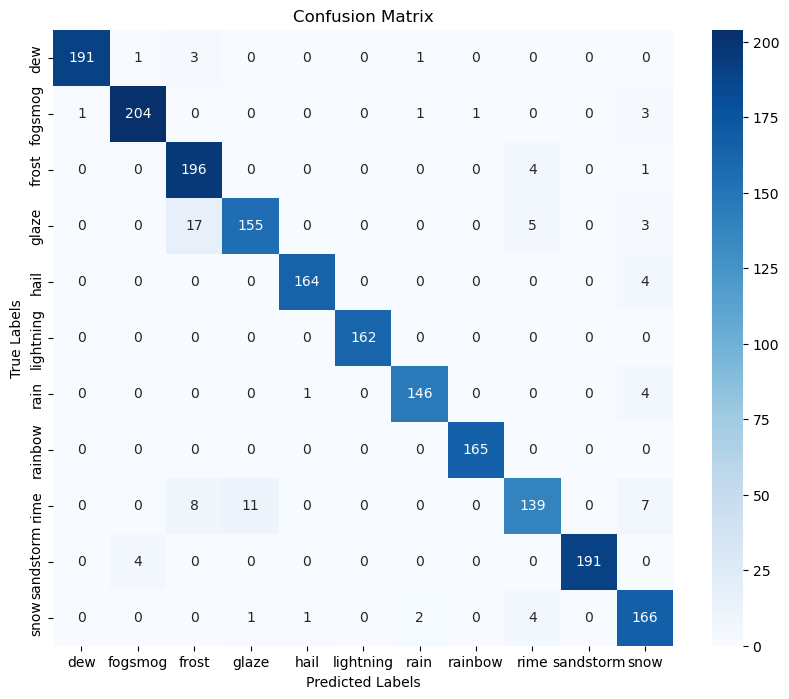

In [90]:
# predictions
predictions_prob = best_model.predict(valid_generator)
predictions = np.argmax(predictions_prob, axis=1)

# classification report
print(classification_report(valid_generator.classes, predictions, target_names=class_labels))

# confusion matrix
cm = confusion_matrix(valid_generator.classes, predictions)

# confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Lets try diffrent Images on our model (Evaluate the best model) :-

In [78]:
class_labels = ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
def load_image_from_path_or_url(img_path_or_url, image_size):
    if img_path_or_url.startswith('http'):
        # image from URL
        response = requests.get(img_path_or_url)
        img = Image.open(BytesIO(response.content))
    else:
        # from local path
        img = Image.open(img_path_or_url)
    
    img = img.resize((image_size, image_size))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Rescale
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    
    return img_array, img

def predict_image_label(model, img_path_or_url, class_labels, image_size):
    img_array, img = load_image_from_path_or_url(img_path_or_url, image_size)

    # predictions
    predictions = best_model.predict(img_array)

    # predicted class
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_labels[predicted_class]

    print(f"Predicted class index: {predicted_class}")
    print(f"Predicted class label: {predicted_label}")

    # image with the predicted label
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Label: {predicted_label}")
    plt.show()


1/1 [==============================] - 2s 2s/step
Predicted class index: 7
Predicted class label: rainbow


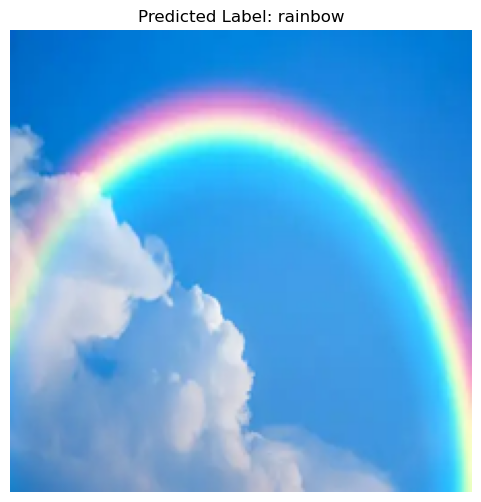

In [79]:
# path to the image
img_path = '/kaggle/input/evaluate-themodel/rainbow_01.webp'
IMAGE_SIZE = 224

# predict and show the image
predict_image_label(best_model_today, img_path, class_labels, IMAGE_SIZE)


1/1 [==============================] - 0s 40ms/step
Predicted class index: 6
Predicted class label: rain


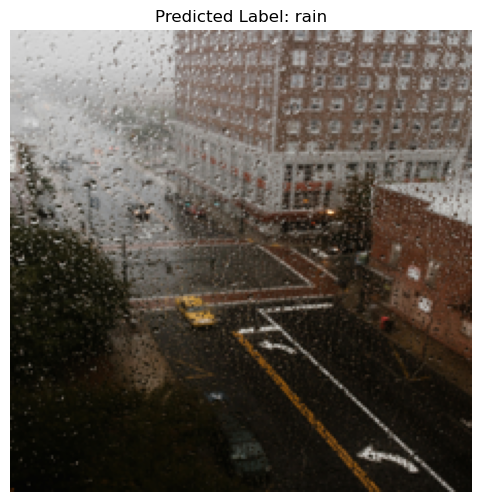

In [85]:
# path to the image
img_path = 'https://images.pexels.com/photos/3178798/pexels-photo-3178798.jpeg'
# IMAGE_SIZE 
IMAGE_SIZE = 224 

# predict and show the image
predict_image_label(best_model_today, img_path, class_labels, IMAGE_SIZE)


1/1 [==============================] - 0s 37ms/step
Predicted class index: 0
Predicted class label: dew


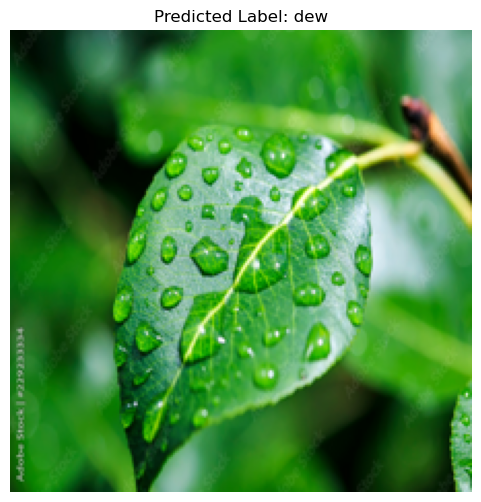

In [81]:
# path to the image
img_path = '/kaggle/input/evaluate-themodel/dew_01.jpg'

IMAGE_SIZE = 224 

# predict and show the image
predict_image_label(best_model_today, img_path, class_labels, IMAGE_SIZE)


1/1 [==============================] - 0s 37ms/step
Predicted class index: 1
Predicted class label: fogsmog


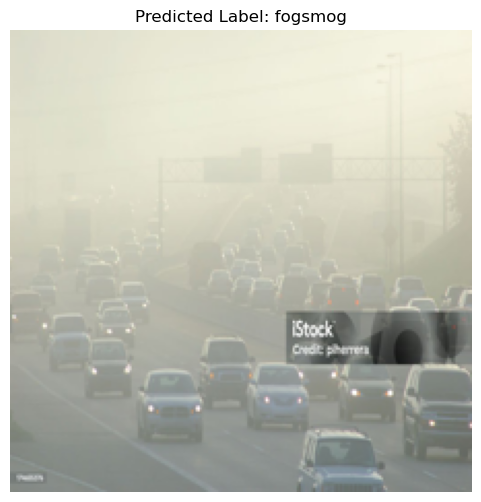

In [82]:
# path or URL to the image
img_path_or_url = 'https://media.istockphoto.com/id/174655376/photo/cars-at-rush-hour-driving-through-thick-smog.jpg?s=1024x1024&w=is&k=20&c=VtREDkyGrJFaJ-BxvML11ja9yFx-s01SFG9FvPtnzoU='  # Replace with your image URL or local file path
IMAGE_SIZE = 224  

# predict and show the image
predict_image_label(best_model_today, img_path_or_url, class_labels, IMAGE_SIZE)

1/1 [==============================] - 0s 38ms/step
Predicted class index: 2
Predicted class label: frost


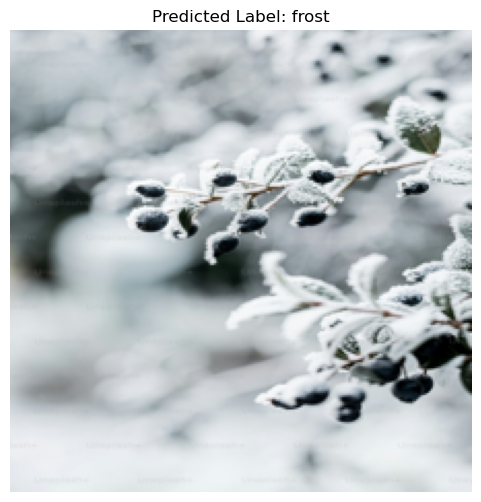

In [83]:
# path or URL to the image
img_path_or_url = 'https://plus.unsplash.com/premium_photo-1670347627514-07a3d37e0670?q=80&w=1376&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D'  # Replace with your image URL or local file path
IMAGE_SIZE = 224

# predict and show the image
predict_image_label(best_model_today, img_path_or_url, class_labels, IMAGE_SIZE)

1/1 [==============================] - 0s 37ms/step
Predicted class index: 3
Predicted class label: glaze


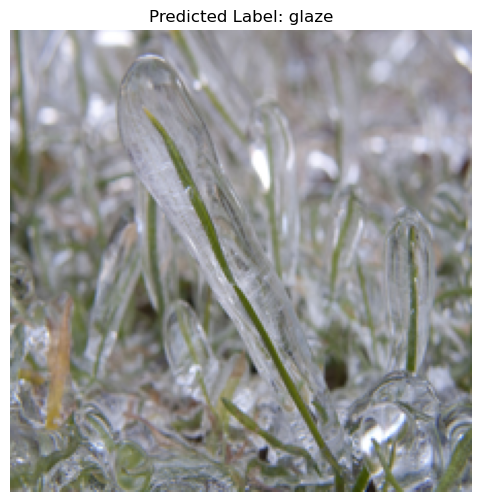

In [88]:
# path to the image
img_path = 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/ba/Ice_on_grass.jpg/1200px-Ice_on_grass.jpg'
IMAGE_SIZE = 224 
# predict and show the image
predict_image_label(best_model_today, img_path, class_labels, IMAGE_SIZE)
